# Overlapping Communication and Computation using CuPy (HPC4WC Project 18)
Pascal Vogel and Ciril Humbel, August 2024

**Note**: To execute code cells in this notebook, please use the Python kernel provided by the course, `HPC4WC_kernel` ([github](https://github.com/ofuhrer/HPC4WC)).

## Introduction

In the examples presented in the course, the typical workflow when using GPUs is to prepare data on the CPU and copy it to the GPU. Then, computations are performed on the GPU. Finally, the results are copied back to the CPU for analysis. For small computational loads, i.e. if few operations are performed per data element, the time required to copy data from and to the GPU can take up a significant part of the overall runtime.

If the computations are independent between different chunks of data, we can improve the performance by splitting the problem set and then overlap computations and data transfers on the different chunks.

Asynchronous execution on NVIDIA GPUs is realised with streams, each of which represents a sequence of computations that are executed in order. Different streams are unrelated to each other and can be executed concurrently, provided that enough resources are available. Success of an overlapping strategy relies on the fact that performing memory transfers in one stream does not require GPU cores, therefore allowing another stream to execute. This strategy can be found, e.g. on the [NVIDIA forum](https://forums.developer.nvidia.com/t/optimal-use-of-streams/18229/12), and it was also briefly discussed during the lecture.

In an idealised setting, we can consider the total execution time a function of the number of data points $d$, where we can split the time into a computational part ($t_k$, kernel time) and a data transfer ($t_c$ copy time): $t = d(t_k + t_c)$. If we split the data into $n$ chunks, the ideal execution time is $t_{opt} = d t_k + \frac{d}{n} t_c$. This is the case because the last DtoH copy cannot be overlapped with any computation.

<div style="text-align: center;">
    <img src="./images/hypothesis1.jpg" width="500" alt="Image Description" />
    <figcaption>Visual representation of splitting the data, and overlapping computation and copying. In this scenario, the data has been split across 1, 2 and n streams</figcaption>
</div>
<br>

In reality, this idealisation is only valid under specific conditions. First, the GPU executes computations on a number of elements concurrently. If we have less data, the runtime will not improve. On the other hand, if we have more elements than can be processed simultaneously, we will have to perform the same computations multiple times on different data segments. So it is required that $d$ and $\frac{d}{n}$ are multiples of the segment size (= the maximum amount of data points that can be on the GPU at once). Second, to be able to hide data transfer behind computations, we have to ensure that the time for the computations on a chunk, $\frac{d}{n} t_k$, is larger than the transfer time, $\frac{d}{n} t_c$.

## Preparatory Considerations

In [1]:
import time

import numpy as np
import cupy as cp
import cupyx as cpx

In [2]:
cp.__version__

'10.1.0'

CuPy introduced asynchronous host-to-device copy only in Version 13 ([cupy docs](https://docs.cupy.dev/en/stable/upgrade.html#change-in-cupy-array-cupy-asarray-cupy-asanyarray-behavior)),
therefore, on Piz Daint, we cannot overlap this operation with computations on other data.

However, we can asynchronously copy data from device to host using the function `get()`, provided that 
a stream is specified and pinned memory is prepared to store the data ([cupy docs](https://docs.cupy.dev/en/v10.6.0/reference/generated/cupy.ndarray.html?highlight=get#cupy.ndarray.get)).

<div style="text-align: center;">
    <img src="./images/hypothesis2.jpg" width="500" alt="Image Description" />
    <figcaption>Adapted representation of splitting the data and overlapping. </figcaption>
</div>
<br>
In the idealized case $t_k = t_c = \frac{1}{2}T$ (computation time = copy time) then the best possible time reduction would be from $T$ to $\left(\frac{1}{2} + \frac{1}{2n}\right)*T$ (where $n$ is the number of streams).

The following code verifies that `get()` can actually be performed asynchronously:

In [3]:
a_gpu= cp.random.rand(2**22, dtype=np.float64)

a_pinned = cpx.empty_like_pinned(a_gpu)

# synchronous get
tic = time.perf_counter()
a_cpu = a_gpu.get()
t_sync = time.perf_counter() - tic

# asynchronous get
s = cp.cuda.get_current_stream()
tic_async = time.perf_counter()
a_gpu.get(stream=s, out=a_pinned)
t_async = time.perf_counter() - tic_async 

s.synchronize() # wait for the async get() to finish, otherwise next time counter starts while the s is not ready to start the operation 

# with explicit synchronisation
tic_expl = time.perf_counter()
a_gpu.get(stream=s, out=a_pinned)
s.synchronize()
t_expl = time.perf_counter() - tic_expl


print("synchronous call:\t",  round(t_sync * 1000, 3), "ms")
print("asynchronous call:\t", round(t_async* 1000, 3), "ms")
print("synchronised call:\t", round(t_expl * 1000, 3), "ms")

synchronous call:	 16.535 ms
asynchronous call:	 0.112 ms
synchronised call:	 2.637 ms


As one can see, the asynchronous call returns very fast. If we wait until the stream has completed the copying (synchronised call), the total time increases. This shows that the call is truly non-blocking.

Also, when comparing the runtime of the different calls, we see that the asynchronous device to host (DtoH) copy is significantly faster than the synchronous version. This shows the impact that pinned memory has on DtoH copy times. In subsequent experiments, we will always use pinned memory, so that we do not include this improvement in our analysis.

## The computational kernel

We considered two different kernels to investigate the overlapping strategy. First, the computation of the Mandelbrot set was tested. This involves a preparation procedure on the CPU, independent computations on the GPU, and a visualisation step on the CPU. The load can be varied by adapting the maximal number of iterations and the resolution of the image.

In [4]:
import matplotlib.pyplot as plt

def mandelbrot(C_in, T_out, r=10**3, max_iter=10**3):
    # create temporary gpu arrays
    C = cp.asarray(C_in)
    T = cp.zeros(C.shape, dtype=cp.int64)
    Z = cp.zeros_like(C)
    
    # perform iterations
    for k in range(np.int64(max_iter)):
        M = abs(Z) < r
        T[M] = T[M] + 1
        Z[M] = Z[M] ** 2 + C[M]
        
    T.get(out=T_out)


In [5]:
nx, ny = 2**10, 2**10
xrange = (-1.4, -1.35)
yrange = (0., 0.05)

x = np.linspace(*xrange, nx)
y = np.linspace(*yrange, ny)

X, Y = np.meshgrid(x, y)
C = (X + Y * 1j)
T = cpx.zeros_pinned(C.shape, dtype=np.int64)

mandelbrot(C, T)

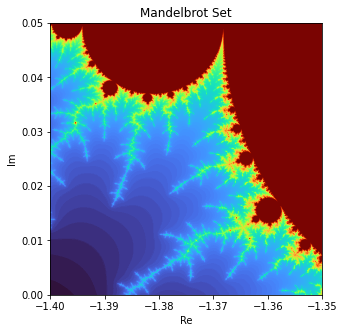

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(np.log10(T), extent=[*xrange, *yrange], cmap="turbo")
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()


For completeness, we provide all the additional code that was used to experiment with the Mandelbrot set in a separate notebook `mandelbrot_experiments.ipynb`.

The second approach was to generate a vector of initial values and repeatedly compute the arc tangent of each element. This kernel has the additional advantage that the array is only one-dimensional, which greatly simplifies the splitting into equally-sized tasks. 
The experimental code for the arctan can be found in the `arctan_experiments.ipynb`.

For the following experiments, we decided to work only with the arctan-kernel. Apart from the advantage described above, it is also easier to generate the initial data directly on the GPU, which is beneficial since we cannot hope to overlap host-to-devide copies.

In [7]:
def iterate_arctan(n, i):
    result = cp.ones(n, dtype=np.float64)
    for _ in range(i):
        result = cp.arctan(result)
    return result

## Using Multiple Streams

To familiarise ourselves with the general concepts and check that streams actually work, we first use two streams to execute the arctan-kernel and perform DtoH copy.

We also use `cuda.Events` to record how long it takes between the completion of the first and second streams. If this value is similar to or larger than the time required for the copy of the data, it could be hidden behind computations.

Note that we have added a 'warm up call' as the loading of modules happens when accessing the GPU for the first time. 
<div style="text-align: center;">
    <img src="./images/warm_up.jpg" width="800" alt="Image Description" />
    <figcaption>Profile showing the loading of modules (once for filling the array and once for the arctan function).</figcaption>
</div>
<br>

Another thing we did was calling `cp.get_default_memory_pool().free_all_blocks()`. We noticed that some batch experiments (where we try different stream amounts in a loop) resulted in unreasonable results. Our guess is that at some point the memory on the GPU was, full and then it was freeing it automatically, but this means that we measured that freeing time as well. To avoid this, we decided to manually free the memory before doing tests with multiple different chunk sizes.

As mentioned earlier, in the optimal case, we have $t_k = t_c$. This means we had to find out how many iterations of arctan (or more generally, how many FLOP) can be executed in the time an element is copied (depending on the bus transfer capacity). Through testing we figured that about 20 iterations of arctan per data point (double precision) is a good approximation to the optimal case (full occupancy of the GPU and memory bus).

We used 50 runs to average over to ensure the stability of the results.
We start our experiments by using two streams instead of one.

In [8]:
n = 2**22
niter = 20
nstreams = 2

streams = [cp.cuda.Stream(non_blocking=True) for _ in range(nstreams)]
results = [cpx.empty_pinned(n, dtype=np.float64) for _ in range(nstreams)]
ends    = [cp.cuda.Event() for _ in range(nstreams)]

result  = cpx.empty_pinned(n*nstreams, dtype=np.float64)

# warmup call 
iterate_arctan(n, niter)

# two-stream version
tic = time.perf_counter()
for s, e, res in zip(streams, ends, results):
    with s:
        iterate_arctan(n, niter).get(stream=s, out=res)
        s.record(e)
t_calls = (time.perf_counter() - tic) * 1000  # milliseconds

for s in streams:
    s.synchronize()
    
t_two = (time.perf_counter() - tic) * 1000  # milliseconds

t_diff = cp.cuda.get_elapsed_time(ends[0], ends[-1])

# comparison using a single stream
tic = time.perf_counter()
iterate_arctan(n*nstreams, niter).get(out=result)
cp.cuda.runtime.deviceSynchronize()  # synchronisation required since here get is also asynchronous
t_single = (time.perf_counter() - tic) * 1000  # milliseconds


print("time using one stream:\t", round(t_single, 5), "ms")
print("time using two streams:\t", round(t_two, 5), "ms")
print("between completions:\t", round(t_diff, 5), "ms")

time using one stream:	 10.76804 ms
time using two streams:	 11.98062 ms
between completions:	 2.55296 ms


We observe that the execution on one stream is actually faster than on two streams. In addition, we see that the elapsed time between the completion of the two streams is similar, but rather smaller than the time required for the data transfer (see preparatory considerations).

In a second step, we try to vary the number of streams to see if we can achieve more overlapping.

In [9]:
def run_several_streams(nstreams, n=2**22, niter=20):
    assert n % nstreams == 0, "n must be divisible by number of streams"
    nloc = n // nstreams
    
    streams = [cp.cuda.Stream(non_blocking=True) for _ in range(nstreams)]
    results = [cpx.empty_pinned(nloc, dtype=np.float64) for _ in range(nstreams)]
    ends    = [cp.cuda.Event() for _ in range(nstreams)]
    
    tic = time.perf_counter()
    for s, e, res in zip(streams, ends, results):
        with s:
            iterate_arctan(nloc, niter).get(stream=s, out=res)
            s.record(e)
    for s in streams:
        s.synchronize()

    t_end = (time.perf_counter() - tic) * 1000

    t_diff = [cp.cuda.get_elapsed_time(ends[i], ends[i+1]) for i in range(nstreams-1)]
    
    return t_end, np.mean(t_diff)
    
    
def run_one_stream(n=2**22, niter=20):
    result = cpx.empty_pinned(n, dtype=np.float64)

    tic = time.perf_counter()
    iterate_arctan(n, niter).get(out=result)
    cp.cuda.runtime.deviceSynchronize()
    t_end = (time.perf_counter() - tic) * 1000
    
    return t_end
    

In [10]:
# wrapper function for test runs
def test_several_streams(nelems, nruns, niter):
    run_one_stream(nelems, niter) # warmup

    # establish a baseline
    t_1 = 0.
    for _ in range(nruns):
        t_1 += run_one_stream(nelems, niter)

    t_1 /= nruns
    print("=== single stream with", nelems, "elements  ===")
    print("total time:", round(t_1, 5), "ms")
    
    for s in [2, 4, 6, 8, 12, 16, 24]:
        output = np.zeros(2)
        for _ in range(nruns):
            cp.get_default_memory_pool().free_all_blocks() # free memory, weird results if we don't do it here, explanations later on
            output += run_several_streams(s, nelems,niter)

        t_s, t_diff = output / nruns
        print("")
        print("===", s, "streams ===")
        print("improvement:", round(t_1 - t_s, 5) , f"ms ({round(100 * (t_1 - t_s) / t_1, 1)}%)")
        print("average time between streams to finish:", round(t_diff, 5), "ms")

In [11]:
test_several_streams(nelems=6*2**20, nruns=50, niter=20)

=== single stream with 6291456 elements  ===
total time: 7.72411 ms

=== 2 streams ===
improvement: -0.33483 ms (-4.3%)
average time between streams to finish: 1.91248 ms

=== 4 streams ===
improvement: 1.25772 ms (16.3%)
average time between streams to finish: 1.10626 ms

=== 6 streams ===
improvement: 2.23523 ms (28.9%)
average time between streams to finish: 0.72553 ms

=== 8 streams ===
improvement: 2.54934 ms (33.0%)
average time between streams to finish: 0.54428 ms

=== 12 streams ===
improvement: 0.77965 ms (10.1%)
average time between streams to finish: 0.53878 ms

=== 16 streams ===
improvement: -1.26255 ms (-16.3%)
average time between streams to finish: 0.54254 ms

=== 24 streams ===
improvement: -5.41043 ms (-70.0%)
average time between streams to finish: 0.53987 ms


We do already get some speedups. The best is achieved with 8 streams. Let's try a different array size.

In [12]:
test_several_streams(nelems=6*2**22, nruns=50, niter=20)

=== single stream with 25165824 elements  ===
total time: 30.56556 ms

=== 2 streams ===
improvement: -1.95977 ms (-6.4%)
average time between streams to finish: 7.63247 ms

=== 4 streams ===
improvement: 1.45368 ms (4.8%)
average time between streams to finish: 1.27346 ms

=== 6 streams ===
improvement: 4.06616 ms (13.3%)
average time between streams to finish: 2.60733 ms

=== 8 streams ===
improvement: 5.51618 ms (18.0%)
average time between streams to finish: 1.49133 ms

=== 12 streams ===
improvement: 7.93865 ms (26.0%)
average time between streams to finish: 1.51641 ms

=== 16 streams ===
improvement: 9.71153 ms (31.8%)
average time between streams to finish: 1.12511 ms

=== 24 streams ===
improvement: 12.2267 ms (40.0%)
average time between streams to finish: 0.71561 ms


We observe that now the optimal amount of streams has shifted. This suggests that we should investigate chunk sizes.

## Optimal Chunk Sizes
We expect to achieve the best performance if each stream processes exactly as many elements as can be handled by the GPU concurrently. In this way, we do not waste processing units that would otherwise be waiting.

The Tesla P100 PCIe 16GB GPU has a theoretical performance of 4.763 TFLOPS for double precision and a boost clock speed of 1329 MHz ([datasheet](https://www.techpowerup.com/gpu-specs/tesla-p100-pcie-16-gb.c2888)). Dividing these values gives us $\frac{4.763 \cdot 10^{12}}{1.329 \cdot 10^{9}} \approx 3584$ processing units (i.e. operations per cycle).

Note that we used chunks and blocks as synonyms after this point.

In [13]:
# method A
def run_several_streams_with_size(size=2**20, n=2**22, niter=20):
    if n % size:
        nstreams = n // size + 1
    else:
        nstreams = n // size
        
    streams = [cp.cuda.Stream(non_blocking=True) for _ in range(nstreams)]
    results_cpu = [cpx.empty_pinned(size, dtype=np.float64) for _ in range(nstreams)]

    tic = time.perf_counter()
    for s, res_cpu in zip(streams, results_cpu):      
        with s:
            iterate_arctan(size, niter).get(stream=s, out=res_cpu)             
            
    for s in streams:
        s.synchronize()
  
    t = (time.perf_counter() - tic) * 1000
    return t, nstreams

In [14]:
nruns = 50
n     = 2**24

run_one_stream(n) # warmup

# establish a baseline
t_1 = 0.
for _ in range(nruns):
    t_1 += run_one_stream(n)
    
t_1 /= nruns

t_s = 0.
for _ in range(nruns):
    t_s += run_several_streams_with_size(size=3584, n=n)[0]
        
t_s /=  nruns
print("")
print("improvement:", round(t_1 - t_s, 5) , f"ms ({round(100 * (t_1 - t_s) / t_1, 1)}%)")


improvement: -1048.23964 ms (-5135.0%)


As we can see, using 3584 as chunk size leads to awfully long calculation times. We conclude that a larger amount of elements has to be included in each chunk to utilise the GPU. Therefore, we try to find a good value for the chunk size by experiment.

In [15]:
# function for running experiments used by all following methods
def test_method(method, nelems, nruns, niter, min_size_log_2, max_size_log_2):
    run_one_stream(nelems, niter) # warmup

    # baseline
    t_1 = 0.
    for _ in range(nruns):
        t_1 += run_one_stream(nelems, niter)

    t_1 /= nruns

    print("=== single stream with", nelems, "elements  ===")
    print("total time:", round(t_1, 5), "ms")

    for size in [2**i for i in range(min_size_log_2, max_size_log_2)]:
        output = np.zeros(2)
        cp.get_default_memory_pool().free_all_blocks() # free memory
        run_one_stream(nelems, niter) # to reallocate memory

        for _ in range(nruns):
            output += method(size, nelems, niter)

        t_s, nstreams = output / nruns

        print("")
        print(f"=== {int(nstreams)} streams ({size} elements) ===")
        imp = (t_1 - t_s)
        print("average improvement:", round(imp, 5) , f"ms ({round(100 * imp / t_1, 1)}%)")


In [16]:
test_method(method=run_several_streams_with_size, nelems=2**24, nruns=50, niter=20, min_size_log_2=12, max_size_log_2=24)

=== single stream with 16777216 elements  ===
total time: 20.41146 ms

=== 4096 streams (4096 elements) ===
average improvement: -906.4443 ms (-4440.9%)

=== 2048 streams (8192 elements) ===
average improvement: -442.84959 ms (-2169.6%)

=== 1024 streams (16384 elements) ===
average improvement: -213.74229 ms (-1047.2%)

=== 512 streams (32768 elements) ===
average improvement: -98.821 ms (-484.1%)

=== 256 streams (65536 elements) ===
average improvement: -42.72501 ms (-209.3%)

=== 128 streams (131072 elements) ===
average improvement: -15.9809 ms (-78.3%)

=== 64 streams (262144 elements) ===
average improvement: -5.04126 ms (-24.7%)

=== 32 streams (524288 elements) ===
average improvement: 1.30591 ms (6.4%)

=== 16 streams (1048576 elements) ===
average improvement: 5.61419 ms (27.5%)

=== 8 streams (2097152 elements) ===
average improvement: 5.14859 ms (25.2%)

=== 4 streams (4194304 elements) ===
average improvement: 2.87072 ms (14.1%)

=== 2 streams (8388608 elements) ===
avera

According to this experiment, having small block sizes and, therefore, also many streams, seems not to be beneficial in any case, reinforcing the result found earlier. A chunk size of $2^{20}=1'048'576$  yielded the best improvement. Let's try another total size.

In [17]:
test_method(method=run_several_streams_with_size, nelems=2**26, nruns=50, niter=20, min_size_log_2=18, max_size_log_2=26)

=== single stream with 67108864 elements  ===
total time: 81.3444 ms

=== 256 streams (262144 elements) ===
average improvement: 5.20376 ms (6.4%)

=== 128 streams (524288 elements) ===
average improvement: 26.02084 ms (32.0%)

=== 64 streams (1048576 elements) ===
average improvement: 31.17722 ms (38.3%)

=== 32 streams (2097152 elements) ===
average improvement: 17.88909 ms (22.0%)

=== 16 streams (4194304 elements) ===
average improvement: 12.12661 ms (14.9%)

=== 8 streams (8388608 elements) ===
average improvement: -0.40954 ms (-0.5%)

=== 4 streams (16777216 elements) ===
average improvement: -23.18638 ms (-28.5%)

=== 2 streams (33554432 elements) ===
average improvement: -17.34728 ms (-21.3%)


Again, chunk size $2^{20}$  led to the best improvement. We now want to find out how these result came to be.

## Profiling Results
To investigate what actually happens on the GPU, we profile a script-version of our code using `nvprof` and inspect the output in the visual profiler contained in the NVIDIA toolkit ([docs](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#)).

In the `arctan.py` we copied the functions from this notebook for running them with the profiler.

For this experiment, we further increased the number of elements while simultaneously reducing the number of runs to prevent long execution times.
With the command 

`nvprof --export-profile ./profiles/method_A.prof -f --openacc-profiling off python3 arctan.py --method A --n_elems 2**24 --block_size 2**22` 

we created a profile for the tasks run on the GPU. The improvement reached for this example was $15.3\%$. The optimal speedup for the idealized case would be $\frac{1}{\frac{1}{2}+\frac{1}{8}} = 1.60$ i.e. $60\%$

<div style="text-align: center;">
    <img src="./images/method A n_elems 2^24 block_size 2^22.jpg" width="1000" alt="Image Description" />
    <figcaption>Profile of the program run with multiple streams (method A). The small violet blocks are the array filling operations. The turquoise blocks represent one iteration (dummy computation) for a block of data. The golden block is the copy back to host.</figcaption>
</div>
<br>
The profile shows that when multiple streams are created, iterations are performed in an interleaved fashion, doing one for each stream before continuing to the next. It is like a FIFO queue, where a stream can have at most one iteration registered. This prevents the desired optimal overlapping, since several streams finish computations almost at the same time and then have to wait for the data transfer. This does not happen with all chunk sizes, which is why, e.g. $2^{20}$ performs quite well already. 

## Ensuring Overlap
We want to make sure that all but the last stream can perform their DtoH copy while another stream is doing their computation. To achieve this, we explicitly synchronise after each stream is done with the computations. The next stream only starts execution after the synchronisation, which will then overlap with the data transfer performed on the previous stream.

In [18]:
# method B
def run_several_streams_sync(size=3584, n=2**22, niter=20):
    if n % size:
        nstreams = n // size + 1
    else:
        nstreams = n // size
    streams = [cp.cuda.Stream(non_blocking=True) for _ in range(nstreams)] 

    results_cpu = [cpx.empty_pinned(size, dtype=np.float64) for _ in range(nstreams)]
    
    # measurement
    tic = time.perf_counter()
    for s, res_cpu in zip(streams, results_cpu):      
        with s:
            res_gpu = iterate_arctan(size, niter)                   
            s.synchronize()  # wait until computation finished before going to the next iteration

            res_gpu.get(stream=s, out=res_cpu)
            
    for s in streams:
        s.synchronize()
  
    t = (time.perf_counter() - tic) * 1000
    
    return t, nstreams


With this explicit synchronisation we profiled the same experiment again. The command used was:

`nvprof --export-profile ./profiles/method_B.prof -f --openacc-profiling off python3 arctan.py --method B --n_elems 2**24 --block_size 2**22`

The improvement reached for this example was with $26.2\%$ notably greater. 

<div style="text-align: center;">
    <img src="./images/method B n_elems 2^24 block_size 2^22.jpg" width="800" alt="Image Description" />
    <figcaption>Profile of the program run with multiple synchronized streams (method B).</figcaption>
</div>
<br>
We observe that now the overlap is what we assumed it would look like in our hypothesis.

Let's test the synchronised method with different block sizes.

In [19]:
test_method(method=run_several_streams_sync, nelems=2**24, nruns=50, niter=20, min_size_log_2=18, max_size_log_2=24)

=== single stream with 16777216 elements  ===
total time: 20.40674 ms

=== 64 streams (262144 elements) ===
average improvement: -5.09496 ms (-25.0%)

=== 32 streams (524288 elements) ===
average improvement: -1.2898 ms (-6.3%)

=== 16 streams (1048576 elements) ===
average improvement: 3.48119 ms (17.1%)

=== 8 streams (2097152 elements) ===
average improvement: 3.79317 ms (18.6%)

=== 4 streams (4194304 elements) ===
average improvement: 5.61249 ms (27.5%)

=== 2 streams (8388608 elements) ===
average improvement: 3.87182 ms (19.0%)


With the given parameters, we see speedups for configurations where we used relatively large chunk sizes.

One question that poses itself is: 
- Why does block size 3584 perform so badly if it is the amount of data that can fit onto the GPU at once?
To answer this question we profiled the following run:

`nvprof --export-profile ./profiles/method_B_3584.prof -f --openacc-profiling off python3 arctan.py --method B --n_elems 2**20 --block_size 3584`

The 'improvement' was: $-9622.2\%$.

We notice that a single iteration with $2^{20}$ elements takes about $33\mu s$ when run with only one stream. For multiple streams, a single iteration with $3584$ elements per stream takes about $1.8\mu s$. So we have $\frac{2*{20}}{3584}\approx 293$ times fewer elements per stream, but it only takes $\frac{33}{1.8} \approx 18$ times less time to compute one iteration of arctan. This at least partially explains why this call took almost 100 times more time than the baseline. But there is still a factor of about 5 to be explained.
We assume context switches on the GPU also take time. We also assume there is a lot of stream overhead overall. To reduce this overhead, we decided to spawn as few streams as possible (namely 2) and let them alternately compute and copy a batch.

In [20]:
# method C
def run_two_streams_sync(size=3584, n=2**24, niter=20):
    if n % size:
        nstreams = n // size + 1
    else:
        nstreams = n // size
    streams = [cp.cuda.Stream(non_blocking=True) for _ in range(2)] 

    results_cpu = [cpx.empty_pinned(size, dtype=np.float64) for _ in range(nstreams)]
    
    # measurement
    tic = time.perf_counter()
    i=0
    for res_cpu in results_cpu:      # did check, streams are alternating
        s = streams[i%2]
        with s:    
            res_gpu = iterate_arctan(size, niter)                   
            s.synchronize()  # wait until computation finished before going to the next iteration

            res_gpu.get(stream=s, out=res_cpu)
            i += 1

    for s in streams:
        s.synchronize()
  
    t = (time.perf_counter() - tic) * 1000
    
    return t, nstreams



A short inspection of the profile generated by

`nvprof --export-profile ./profiles/method_C.prof -f --openacc-profiling off python3 arctan.py --method C --n_elems 2**24 --block_size 2**22`

shows that our change achieved what we wanted. Now two streams share the total workload and do the calculation and copying of one chunk at once. With $29.7\%$ we made an even greater improvement than before. Our assumption that many streams generate more overhead seems to have been reasonable. In the profile, we observe that the second stream does not instantly start with the computation once the first is finished, so there is likely some initialisation time there.
<div style="text-align: center;">
    <img src="./images/method C n_elems 2^24 block_size 2^22.jpg" width="800" alt="Image Description" />
    <figcaption>Profile of the program run with two synchronized streams (method C)</figcaption>
</div>
<br>

Let's check if the behaviour checks out for other chunk sizes aswell.

In [21]:
test_method(method=run_two_streams_sync, nelems=2**24, nruns=50, niter=20, min_size_log_2=18, max_size_log_2=24)

=== single stream with 16777216 elements  ===
total time: 20.41096 ms

=== 64 streams (262144 elements) ===
average improvement: 3.8565 ms (18.9%)

=== 32 streams (524288 elements) ===
average improvement: 5.72581 ms (28.1%)

=== 16 streams (1048576 elements) ===
average improvement: 6.88066 ms (33.7%)

=== 8 streams (2097152 elements) ===
average improvement: 7.23294 ms (35.4%)

=== 4 streams (4194304 elements) ===
average improvement: 6.1461 ms (30.1%)

=== 2 streams (8388608 elements) ===
average improvement: 3.89003 ms (19.1%)


This seems to be the case. Now let's do a thorough testing of all methods with different problem sizes and chunk sizes, and then plot the results.

In [22]:
nelems = 2**24
niter = 20
nruns = 50

# warmup
run_one_stream(nelems, niter)

plot_points = {}

for nelems in [2**i for i in range(20, 29)]:
    t_1 = 0.
    for _ in range(nruns):
        t_1 += run_one_stream(nelems, niter)
    t_1 /= nruns

    plot_points[nelems] = {
        'sizes': [],
        'imp_several_streams': [],
        'imp_several_streams_sync': [],
        'imp_two_streams_sync': []
    }    
    for size in [2**j for j in range(18, int(np.log2(nelems)))]: #removed the +1
        plot_points[nelems]['sizes'].append(size)
        
        output = np.zeros(2)
        cp.get_default_memory_pool().free_all_blocks() # free memory
        
        for _ in range(nruns):
            output += run_several_streams_with_size(size, nelems, niter)

        t_s, nstreams = output / nruns
        imp = (t_1 - t_s) / t_1
        plot_points[nelems]['imp_several_streams'].append(imp)
        
        output = np.zeros(2)
        cp.get_default_memory_pool().free_all_blocks() # free memory
              
        for _ in range(nruns):
            output += run_several_streams_sync(size, nelems, niter)

        t_s, nstreams = output / nruns
        imp = (t_1 - t_s) / t_1
        plot_points[nelems]['imp_several_streams_sync'].append(imp)
        
        output = np.zeros(2)
        cp.get_default_memory_pool().free_all_blocks() # free memory
        
        for _ in range(nruns):
            output += run_two_streams_sync(size, nelems, niter)

        t_s, nstreams = output / nruns
        imp = (t_1 - t_s) / t_1
        plot_points[nelems]['imp_two_streams_sync'].append(imp)

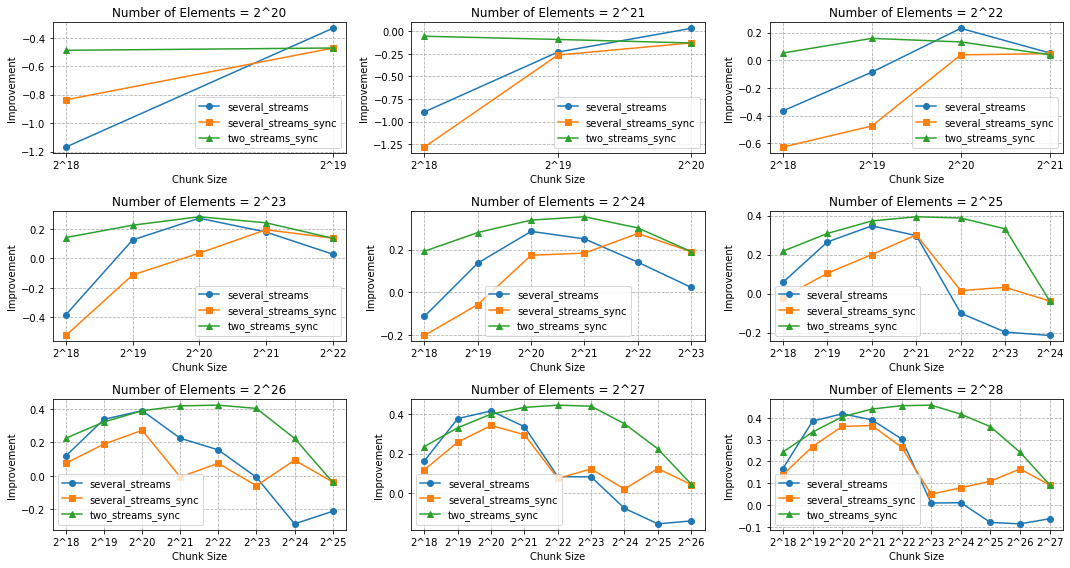

In [23]:
import matplotlib.pyplot as plt

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 8))  # Adjust the figsize to make plots smaller
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

# Plotting the results
for idx, (nelems, data) in enumerate(plot_points.items()):
    ax = axes[idx]
    
    # Plot for each method
    ax.plot(data['sizes'], data['imp_several_streams'], marker='o', label='several_streams')
    ax.plot(data['sizes'], data['imp_several_streams_sync'], marker='s', label='several_streams_sync')
    ax.plot(data['sizes'], data['imp_two_streams_sync'], marker='^', label='two_streams_sync')
    
    # Set x-axis to powers of 2
    ax.set_xscale('log', base=2)  # Set the base of the logarithmic scale to 2
    x_ticks = [size for size in data['sizes'] if size > 0]  # Ensure no zero values
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'2^{int(np.log2(size))}' for size in x_ticks])

    ax.set_xlabel('Chunk Size')
    ax.set_ylabel('Improvement')
    
    # Display nelems as a power of 2 in the title
    nelems_power = int(np.log2(nelems))
    ax.set_title(f'Number of Elements = 2^{nelems_power}')
    
    ax.legend()
    ax.grid(True, which="both", ls="--")

# Adjust layout so titles and labels fit nicely
plt.tight_layout()
plt.show()


These plots give us a good of idea how well our methods perform under different chunk sizes and problem sizes. The conclusions we draw from these plots are the following:
1. The problem size must be large enough. (For array sizes smaller than $2^{21}$ there was no improvement observed.) 
2. The larger the problem size the greater the best possible improvement. 
3. The 'two_streams_sync' (method C) was the most robust one. It almost always outperformed the other two methods.
4. The optimal chunk size depends on the problem size. Large problem sizes have larger optimal chunk sizes than smaller problems.

At this point we could be done, but there is one last thing we would like to do:
We realized towards the end that we should use `cp.get_default_memory_pool().free_all_blocks()` to get rid of some strange/unreasonable results. 
This led us to a closer investigation of the memory allocation. The following profile was created with this command:

`nvprof --export-profile ./profiles/no_malloc.prof -f --openacc-profiling off python3 arctan.py --method C --n_elems 2**24 --block_size 2**22 --n_runs 2`

<div style="text-align: center;">
    <img src="./images/no malloc single.jpg" width="800" alt="Image Description" />
    <figcaption>Profile of the program run with single streams (baseline).</figcaption>
</div>
<br>
We observe that there are two memory allocations before the arctan computations start (beofre and after the violet block standing for the cupy fill). Note that there are two runs in the image. The second run did not have to allocate any memory. Next up, we took a look at the profile from the `two_streams_sync` (method C).
<div style="text-align: center;">
    <img src="./images/no malloc multi.jpg" width="800" alt="Image Description" />
    <figcaption>Profile of the program run with two synchronized streams (method C).</figcaption>
</div>
<br>

We observe the same behavior for the second run as before. Additionally, we noted that even within the first run, when the streams do their second chunk, they do not have to allocate new memory. This means, that each of the two streams only has to allocate $\frac{chunk size}{nelems}$ (in the presented case, $\frac{1}{4}$ of total) memory. This means we have must allocate less memory in total the smaller our chunk sizes are. As allocating memory can take up quite some time, one could argue that this fact should be taken into account for the improvement measurements, which is exactly what we do for our final analysis.

So with a new method that calls `cp.get_default_memory_pool().free_all_blocks()` after every run we did once again a time measurement. Profiling the method with

`nvprof --export-profile ./profiles/malloc.prof -f --openacc-profiling off python3 arctan.py --method malloc --n_elems 2**24 --block_size 2**22 --n_runs 2`

gives the following two plots (for baseline and method C), showing that before each run the memory is in fact newly allocated.

<div style="text-align: center;">
    <img src="./images/malloc single.jpg" width="800" alt="Image Description" />
    <figcaption>Profile of the program run with single stream (baseline) and freeing memory in between runs.</figcaption>
</div>
<br>
<div style="text-align: center;">
    <img src="./images/malloc multi.jpg" width="800" alt="Image Description" />
    <figcaption>Profile of the program run with two streams (method C) and freeing memory in between runs.</figcaption>
</div>
<br>

Let's run another test and then plot the results against the previous ones.

In [24]:
nelems = 2**24
niter = 20
nruns = 50

# warmup
run_one_stream(nelems, niter)

t_1 = 0.
for _ in range(nruns):
    cp.get_default_memory_pool().free_all_blocks() # free memory after each run
    t_1 += run_one_stream(nelems, niter)
t_1 /= nruns

print("=== single stream with", nelems, "elements  ===")
print("total time:", round(t_1, 5), "ms")

for size in [2**i for i in range(18, 24)]:
    output = np.zeros(2)
    for _ in range(nruns):
        cp.get_default_memory_pool().free_all_blocks() # free memory after each run
        output += run_two_streams_sync(size, nelems, niter)

    t_s, nstreams = output / nruns
        
    print("")
    print(f"=== {int(nstreams)} streams ({size} elements) ===")
    imp = (t_1 - t_s)
    print("average improvement:", round(imp, 5) , f"ms ({round(100 * imp / t_1, 1)}%)")

=== single stream with 16777216 elements  ===
total time: 25.94967 ms

=== 64 streams (262144 elements) ===
average improvement: 8.78631 ms (33.9%)

=== 32 streams (524288 elements) ===
average improvement: 11.01637 ms (42.5%)

=== 16 streams (1048576 elements) ===
average improvement: 12.16879 ms (46.9%)

=== 8 streams (2097152 elements) ===
average improvement: 12.07502 ms (46.5%)

=== 4 streams (4194304 elements) ===
average improvement: 10.64415 ms (41.0%)

=== 2 streams (8388608 elements) ===
average improvement: 7.33085 ms (28.3%)


In [25]:
nruns = 50
niter = 20
malloc_measurement = {}

for nelems in [2**i for i in range(20, 29)]:
    t_1 = 0.
    for _ in range(nruns):
        t_1 += run_one_stream(nelems, niter)
    t_1 /= nruns

    malloc_measurement[nelems] = {
        'sizes': [],
        'imp_malloc': []
    }    
    for size in [2**j for j in range(18, int(np.log2(nelems)))]: #removed the +1
        malloc_measurement[nelems]['sizes'].append(size)
        t_1 = 0.
        for _ in range(nruns):
            cp.get_default_memory_pool().free_all_blocks() # free memory
            t_1 += run_one_stream(nelems, niter)
        t_1 /= nruns
        output = np.zeros(2)

        for _ in range(nruns):
            cp.get_default_memory_pool().free_all_blocks() # free memory
            output += run_two_streams_sync(size, nelems, niter)

        t_s, nstreams = output / nruns
        imp = (t_1 - t_s) / t_1
        malloc_measurement[nelems]['imp_malloc'].append(imp)

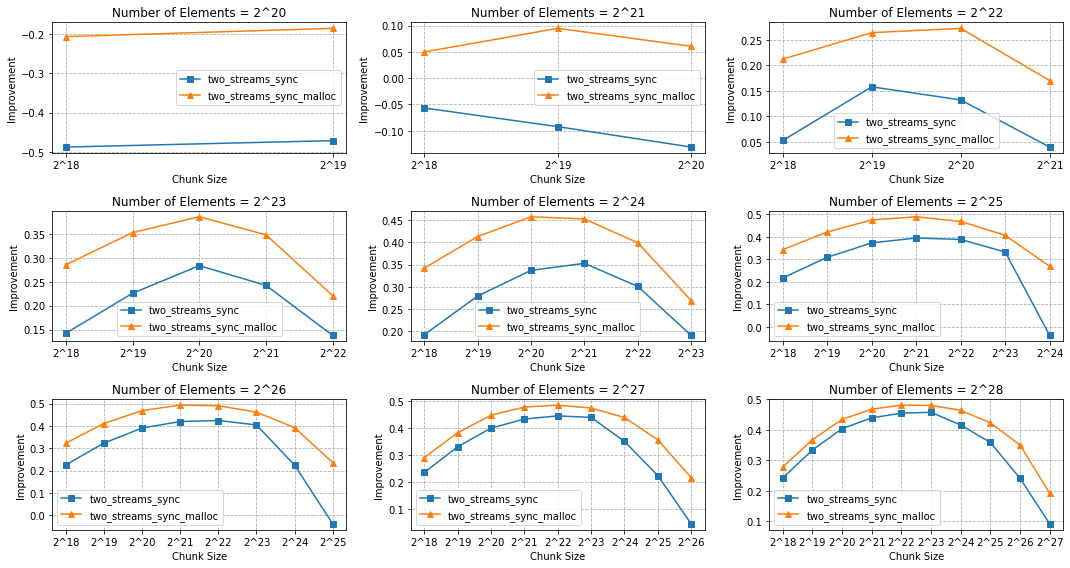

In [26]:
# Plot the malloc against no malloc
fig, axes = plt.subplots(3, 3, figsize=(15, 8))  # Adjust the figsize to make plots smaller
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

# Plotting the results
for idx, (nelems, data) in enumerate(plot_points.items()):
    ax = axes[idx]
    
    # Plot for the two streams method
    ax.plot(data['sizes'], data['imp_two_streams_sync'], marker='s', label='two_streams_sync')
    
    # Plot for the two streams method with malloc
    if nelems in malloc_measurement:
        malloc_data = malloc_measurement[nelems]
        ax.plot(malloc_data['sizes'], malloc_data['imp_malloc'], marker='^', label='two_streams_sync_malloc')
        
    # Set x-axis to powers of 2
    ax.set_xscale('log', base=2)  # Set the base of the logarithmic scale to 2
    x_ticks = [size for size in data['sizes'] if size > 0]  # Ensure no zero values
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'2^{int(np.log2(size))}' for size in x_ticks])

    ax.set_xlabel('Chunk Size')
    ax.set_ylabel('Improvement')
    
    # Display nelems as a power of 2 in the title
    nelems_power = int(np.log2(nelems))
    ax.set_title(f'Number of Elements = 2^{nelems_power}')
    
    ax.legend()
    ax.grid(True, which="both", ls="--")

# Adjust layout so titles and labels fit nicely
plt.tight_layout()
plt.show()

Once again, we want to stress that this is not per se an improvement, it is just another way of defining the improvement.
As we can see, with the improvement definition including memory allocation, we get even better improvements. In our best experiment with idealized conditions, we were able to reach speed-ups of close to $50\%$.

This concludes our analysis of overlapping computation and copying on the GPU.